# XGBOOST Modeling

In [1]:
## 필요한 모듈 호출 ##
try:
    %matplotlib inline
    import xgboost as xgb
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import TimeSeriesSplit
    import pandas as pd
    import numpy as np
    import pickle
except ModuleError:
    !pip install xgboost
    !pip install matplotlib
    !pip install scikit-learn
    !pip install pandas
    !pip install numpy
    %matplotlib inline
    import xgboost as xgb
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import TimeSeriesSplit
    import pandas as pd
    import numpy as np

In [2]:
## 민수용 데이터 불러오기 ##
#제공된 데이터 파일(월별공급량및비중) 사용 / 본 파일과 데이터파일이 같은 폴더에 위치한 후 실행가능
data = pd.read_csv('월별공급량및비중.csv')
civil = data[['YEAR', 'MONTH', "도시가스(톤)_민수용"]]
civil.index = pd.date_range("1996-01-01", "2020-12-01", freq="MS")
ind = data[['YEAR', 'MONTH', "도시가스(톤)_산업용"]]
ind.index = pd.date_range("1996-01-01", "2020-12-01", freq="MS")

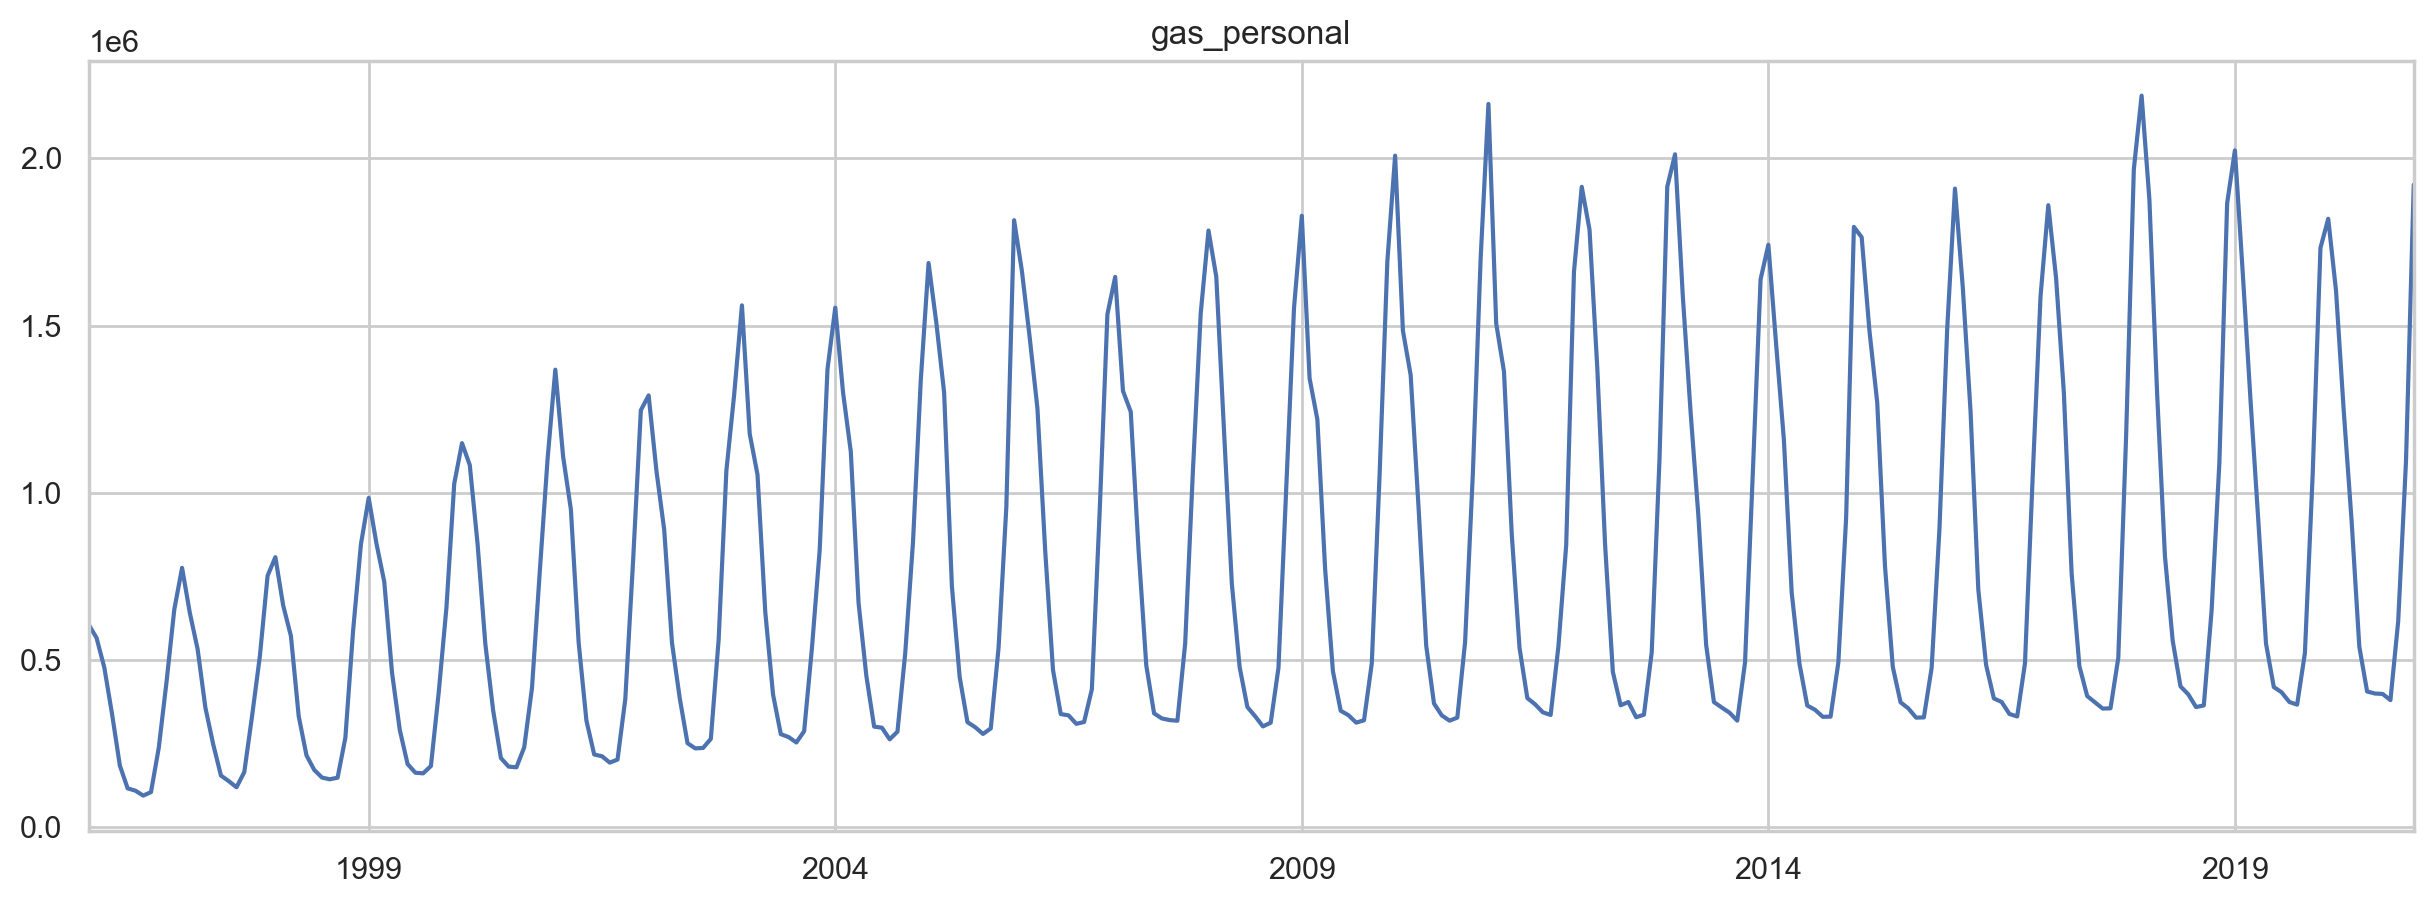

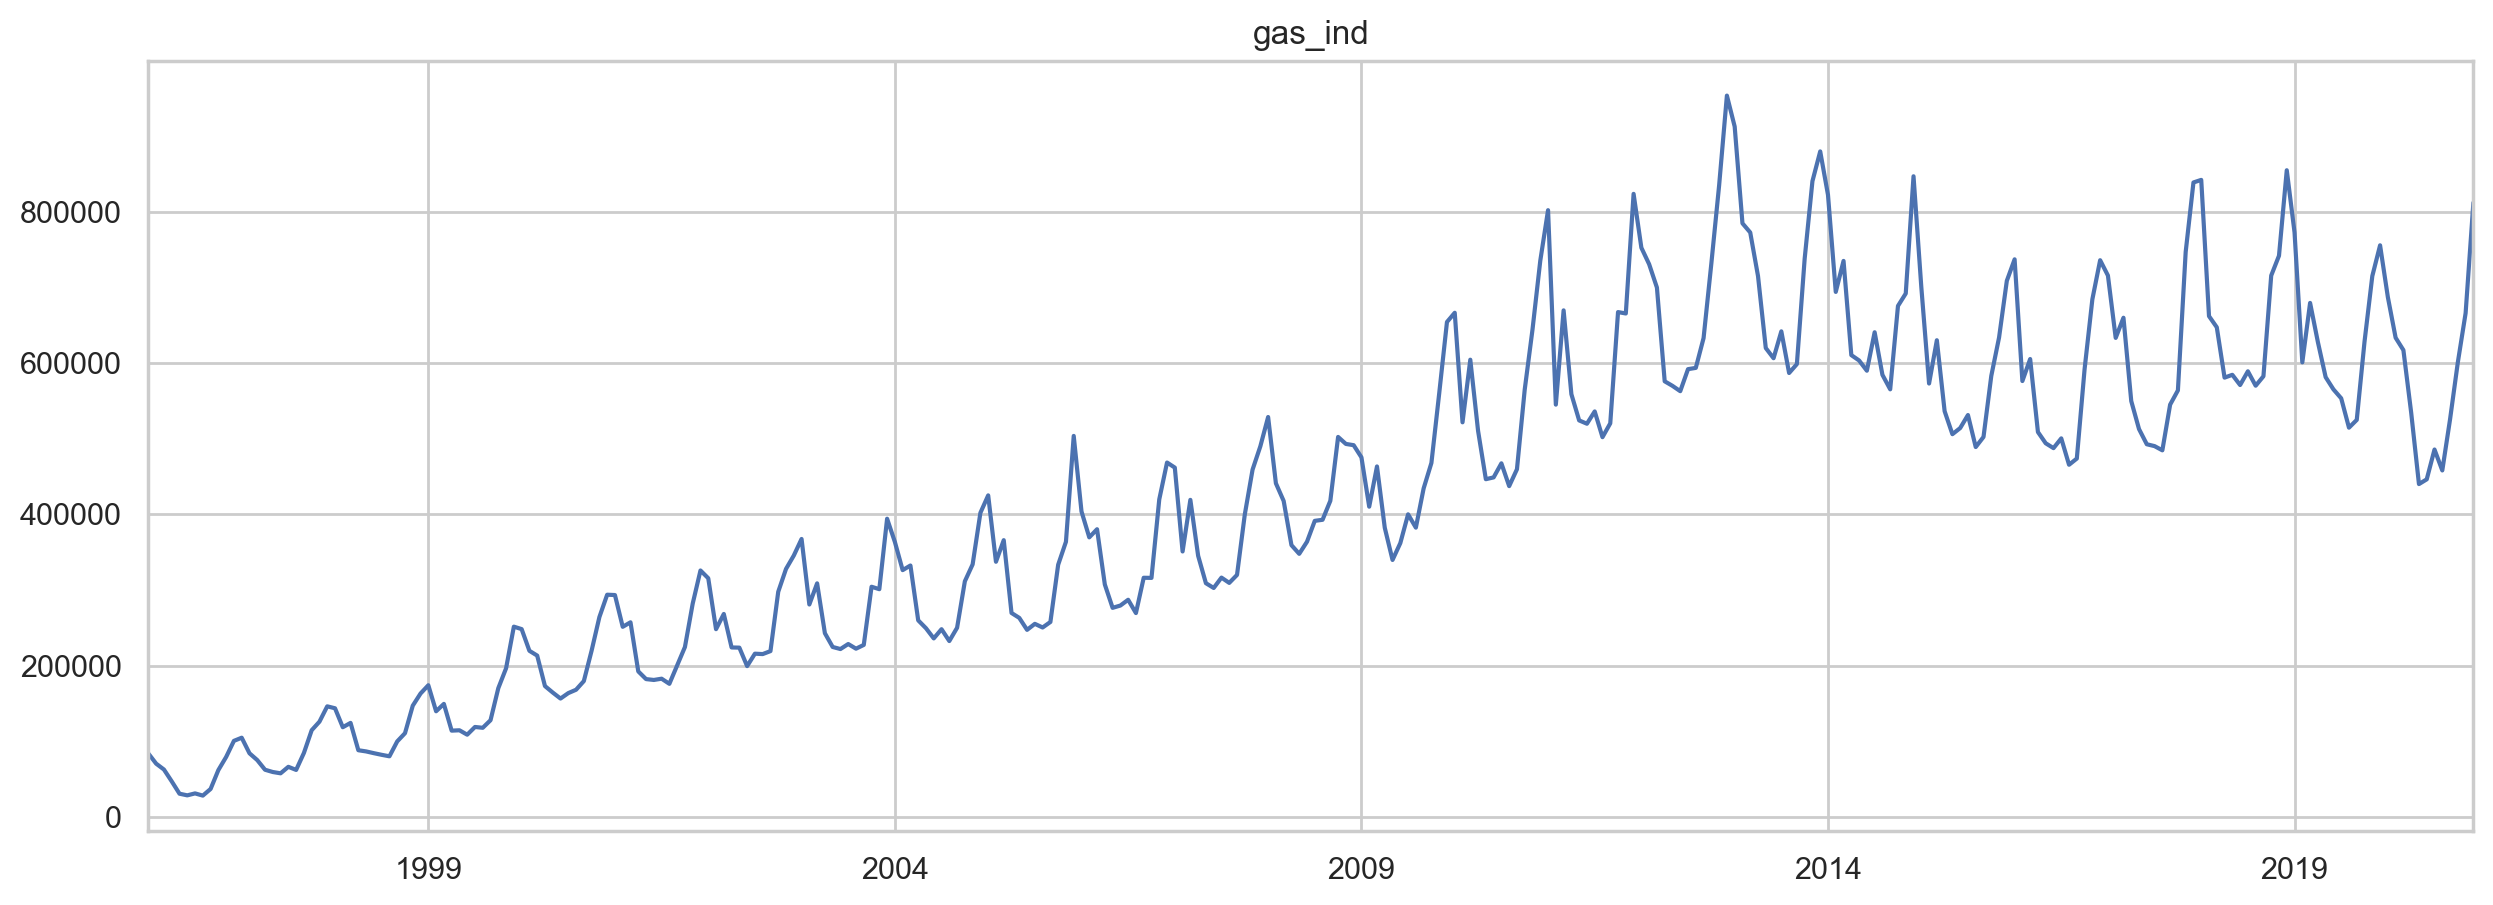

In [3]:
## 불러온 데이터 그래프로 확인 ##
civil['도시가스(톤)_민수용'].plot(style='-', figsize=(15, 5), title='gas_personal')
plt.show()
ind['도시가스(톤)_산업용'].plot(style='-', figsize=(15, 5), title='gas_ind')
plt.show()

In [4]:
## 1년 shift, 2년 shift한 열 추가 ##
def add_lags(df, tf):
    if tf == True: #민수용
        df['lag1'] = df['도시가스(톤)_민수용'].shift(12)
        df['lag2'] = df['도시가스(톤)_민수용'].shift(24)
    else: #산업용
        df['lag1'] = df['도시가스(톤)_산업용'].shift(12)
        df['lag2'] = df['도시가스(톤)_산업용'].shift(24)
    return df

civil = civil.sort_index()
ind = ind.sort_index()
civil = add_lags(civil, True)
ind = add_lags(ind, False)

In [5]:
## 민수용 - XGBOOST Modeling
tss = TimeSeriesSplit(n_splits=7, test_size=12, gap=0)
civil = civil.sort_index()

fold = 0
cpreds = []
cscores = []
for train_idx, val_idx in tss.split(civil):
    #train-test 분리
    ctrain = civil.iloc[train_idx]
    ctest = civil.iloc[val_idx]
    
    #features(X값), target(Y값) 분리
    FEATURES = ['MONTH', 'lag1','lag2']
    TARGET = '도시가스(톤)_민수용'

    cX_train = ctrain[FEATURES]
    cy_train = ctrain[TARGET]

    cX_test = ctest[FEATURES]
    cy_test = ctest[TARGET]
    
    #xgboost 모델 생성
    creg = xgb.XGBRegressor(base_score=0.5,
                           booster='gbtree',    
                           n_estimators=460,
                           objective='reg:squarederror',
                           max_depth=3,
                           eval_metric='mae',
                           learning_rate=0.01)
    #생성한 모델에 fitting
    creg.fit(cX_train, cy_train,
            eval_set=[(cX_train, cy_train), (cX_test, cy_test)],
            verbose=100)
    
    #y값 예측 후 loss 비교 (Evaluation)
    cy_pred = creg.predict(cX_test)
    cpreds.append(cy_pred)
    cscore = np.sqrt(mean_squared_error(cy_test, cy_pred))
    cscores.append(cscore)

[0]	validation_0-mae:708231.56250	validation_1-mae:834893.50000
[100]	validation_0-mae:271401.71875	validation_1-mae:270673.28125
[200]	validation_0-mae:113245.50000	validation_1-mae:89136.63281
[300]	validation_0-mae:59018.87109	validation_1-mae:62342.88672
[400]	validation_0-mae:41569.08203	validation_1-mae:79931.77344
[459]	validation_0-mae:37500.30469	validation_1-mae:86589.10938
[0]	validation_0-mae:714902.25000	validation_1-mae:826874.00000
[100]	validation_0-mae:273466.56250	validation_1-mae:294380.21875
[200]	validation_0-mae:114410.78906	validation_1-mae:89680.28906
[300]	validation_0-mae:60082.93359	validation_1-mae:36784.67578
[400]	validation_0-mae:43978.51562	validation_1-mae:35742.20703
[459]	validation_0-mae:40493.23828	validation_1-mae:39019.20703
[0]	validation_0-mae:720498.81250	validation_1-mae:868480.43750
[100]	validation_0-mae:275168.37500	validation_1-mae:327126.25000
[200]	validation_0-mae:114167.61719	validation_1-mae:135953.12500
[300]	validation_0-mae:59922.8

Score across folds 92592.9128
Fold scores:[129618.35009637885, 63459.00565697836, 60855.23274068962, 106575.91193766177, 147102.4164640553, 71530.77920725504, 69008.6935458452]


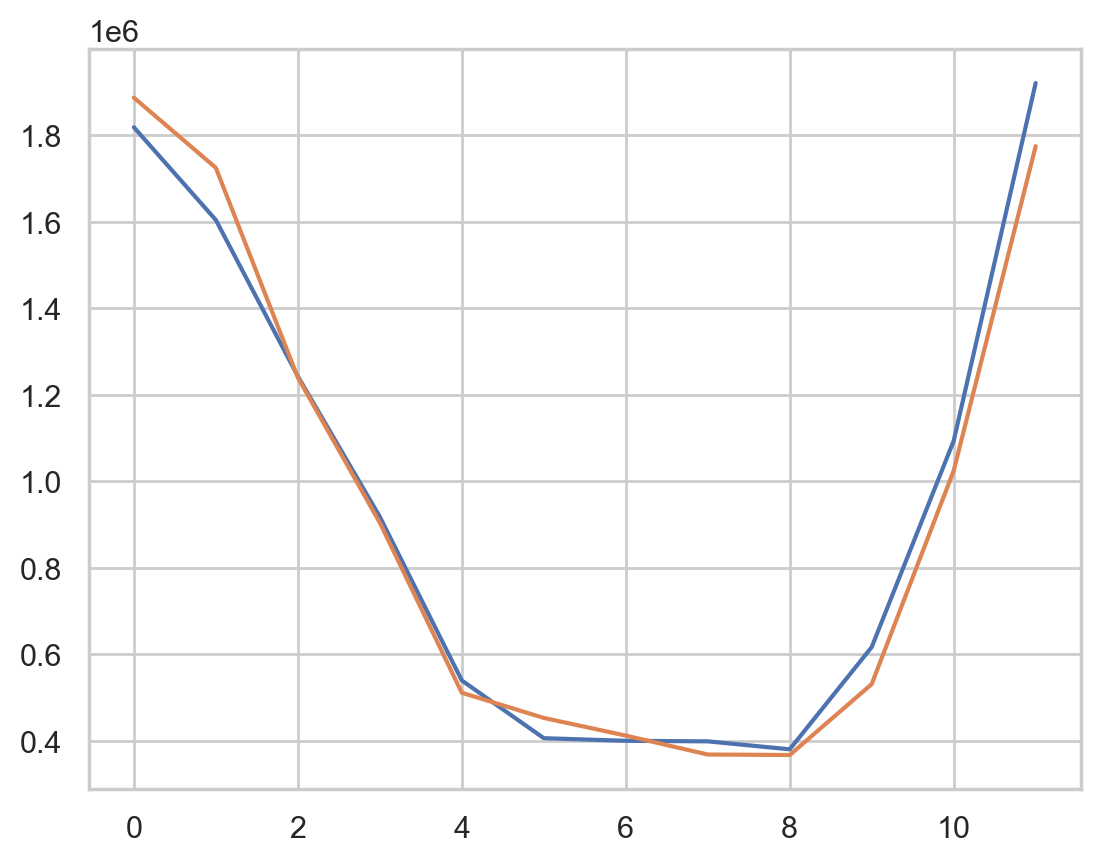

In [6]:
## 민수용 - Evaluation 결과와 그래프 비교
print(f'Score across folds {np.mean(cscores):0.4f}')
print(f'Fold scores:{cscores}')
plt.plot(cy_test.values)
plt.plot(cy_pred)

In [7]:
## 산업용 - XGBOOST Modeling
tss = TimeSeriesSplit(n_splits=7, test_size=12, gap=0)
ind = ind.sort_index()

fold = 0
ipreds = []
iscores = []
for train_idx, val_idx in tss.split(ind):
    #train-test 분리
    itrain = ind.iloc[train_idx]
    itest = ind.iloc[val_idx]
    
    #features(X값), target(Y값) 분리
    FEATURES = ['MONTH', 'lag1','lag2']
    TARGET = '도시가스(톤)_산업용'

    iX_train = itrain[FEATURES]
    iy_train = itrain[TARGET]

    iX_test = itest[FEATURES]
    iy_test = itest[TARGET]
    
    #xgboost 모델 생성
    ireg = xgb.XGBRegressor(base_score=0.5,
                           booster='gbtree',    
                           n_estimators=300,
                           objective='reg:squarederror',
                           max_depth=3,
                           eval_metric='mae',
                           learning_rate=0.01)
    #생성한 모델에 fitting
    ireg.fit(iX_train, iy_train,
            eval_set=[(iX_train, iy_train), (iX_test, iy_test)],
            verbose=100)
    
    #y값 예측 후 loss 비교 (Evaluation)
    iy_pred = ireg.predict(iX_test)
    ipreds.append(iy_pred)
    iscore = np.sqrt(mean_squared_error(iy_test, iy_pred))
    iscores.append(iscore)

[0]	validation_0-mae:337826.81250	validation_1-mae:664578.75000
[100]	validation_0-mae:127965.35938	validation_1-mae:218777.95312
[200]	validation_0-mae:49625.93359	validation_1-mae:46515.35938
[299]	validation_0-mae:24564.50391	validation_1-mae:60327.42578
[0]	validation_0-mae:355038.40625	validation_1-mae:568696.43750
[100]	validation_0-mae:134095.67188	validation_1-mae:141091.96875
[200]	validation_0-mae:51971.76562	validation_1-mae:46811.50000
[299]	validation_0-mae:26295.01953	validation_1-mae:100190.96875
[0]	validation_0-mae:365775.84375	validation_1-mae:565220.81250
[100]	validation_0-mae:137763.54688	validation_1-mae:190822.75000
[200]	validation_0-mae:53451.91406	validation_1-mae:77694.96875
[299]	validation_0-mae:27982.68945	validation_1-mae:68758.96875
[0]	validation_0-mae:375310.37500	validation_1-mae:597001.18750
[100]	validation_0-mae:141048.85938	validation_1-mae:225523.20312
[200]	validation_0-mae:54469.91406	validation_1-mae:80462.83594
[299]	validation_0-mae:28687.96

Score across folds 74246.1081
Fold scores:[73630.1247039724, 112815.32897053116, 77045.0203179841, 60927.553895698264, 89447.29659333591, 42791.35941278573, 63066.07289214377]


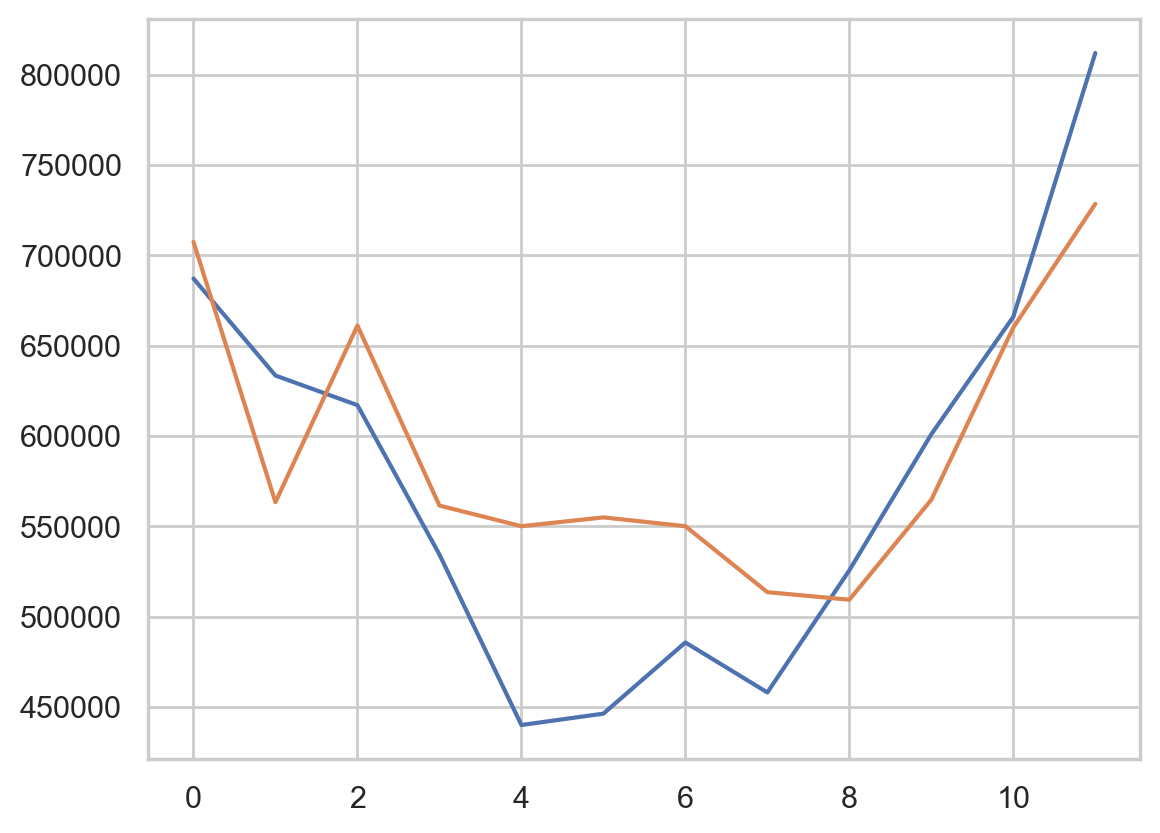

In [8]:
## 산업용 - Evaluation 결과와 그래프 비교
print(f'Score across folds {np.mean(iscores):0.4f}')
print(f'Fold scores:{iscores}')
plt.plot(iy_test.values)
plt.plot(iy_pred)

In [9]:
## 민수용 - 전체 데이터에 대해 재학습 ##
FEATURES = ['MONTH', 'lag1','lag2']
TARGET = '도시가스(톤)_민수용'

cX_all = civil[FEATURES]
cy_all = civil[TARGET]

creg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=460,
                       objective='reg:squarederror',
                       max_depth=3,
                       eval_metric='mae',
                       learning_rate=0.01)
creg.fit(cX_all, cy_all,
        eval_set=[(cX_all, cy_all)],
        verbose=100)

[0]	validation_0-mae:761865.62500
[100]	validation_0-mae:288556.46875
[200]	validation_0-mae:117106.29688
[300]	validation_0-mae:61244.23828
[400]	validation_0-mae:46442.62500
[459]	validation_0-mae:43208.10547


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mae', gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=460, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [10]:
## 산업용 - 전체 데이터에 대해 재학습 ##
FEATURES = ['MONTH', 'lag1','lag2']
TARGET = '도시가스(톤)_산업용'

iX_all = ind[FEATURES]
iy_all = ind[TARGET]

ireg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=300,
                       objective='reg:squarederror',
                       max_depth=3,
                       eval_metric='mae',
                       learning_rate=0.01)
ireg.fit(iX_all, iy_all,
        eval_set=[(iX_all, iy_all)],
        verbose=100)

[0]	validation_0-mae:412936.43750
[100]	validation_0-mae:154484.85938
[200]	validation_0-mae:59719.29297
[299]	validation_0-mae:32665.35352


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mae', gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [11]:
## 모델 저장하기 ##
with open('xgb_civil.pkl', "wb") as f:
    pickle.dump(creg, f)
with open('xgb_ind.pkl', "wb") as f:
    pickle.dump(ireg, f)